In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import gc
import copy

from unet import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
class ImagesWithPaths(Dataset):

    def __init__(self, image_paths, transform=None):
        self.paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = io.imread(path)
        if self.transform:
            image = self.transform(image)
        return image, path
    
    def getitem_bypath(self, path, do_transform=True):
        image = io.imread(path)
        if self.transform and do_transform:
            image = self.transform(image)
        return image

In [3]:
image_paths = sorted(glob.glob("imagenet_flowers/flower64/*.jpg"))
dataset = ImagesWithPaths(image_paths, 
                          transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                         )
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

In [4]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

net = UNet(n_channels=3, n_classes=1).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net = nn.DataParallel(net, list(range(ngpu)))
    
checkpoint = torch.load("model_checkpoints/unet")
net.load_state_dict(checkpoint['model_dict'])

In [5]:
!mkdir imagenet_flowers/mask_pred64
folder = 'imagenet_flowers/mask_pred64'
mask_pred_dict = dict()

net.eval()
with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(dataloader)):
        images, paths = batch[0].to(device), batch[1]
        masks_pred = net(images)
                
        for i in range(masks_pred.size()[0]):
            mask = np.squeeze(masks_pred[i].cpu().numpy())
            file = os.path.split(paths[i])[1]
            path = os.path.join(folder, file)
            mask_pred_dict[file] = mask.mean()
            io.imsave(path, mask)  

pd.Series(mask_pred_dict).to_csv('imagenet_flowers/mask_pred_dict.csv')

mkdir: cannot create directory ‘imagenet_flowers/mask_pred64’: File exists


0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
2it [00:00,  4.53it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n11814584_20982_2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
15it [00:02,  6.76it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/

542it [01:16,  7.93it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12890265_16752_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12890265_7256_2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
584it [01:23,  4.58it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12884260_1747_2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
586it [01:23,  5.89it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12884260_19634_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
614it [01:27,  7.05it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n11665372_8141_2.jpg i

1085it [02:37,  3.86it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12093600_6866_2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
1107it [02:40,  7.41it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12884260_2046_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
1113it [02:41,  7.78it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12058630_3016_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
1127it [02:42,  7.07it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pred64/n12064389_1917_2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
1132it [02:43,  7.58it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: imagenet_flowers/mask_pr

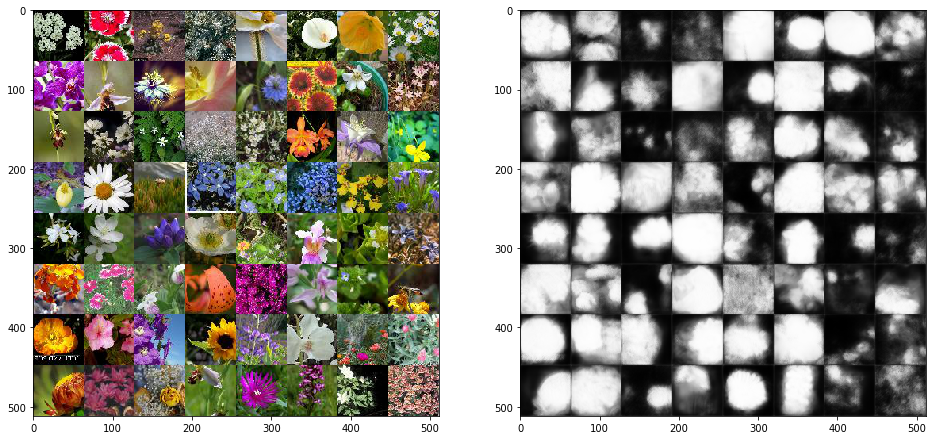

In [6]:
batch = next(iter(dataloader))
pred_masks = net(batch[0].to(device)).detach()
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("test on validation")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(pred_masks.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

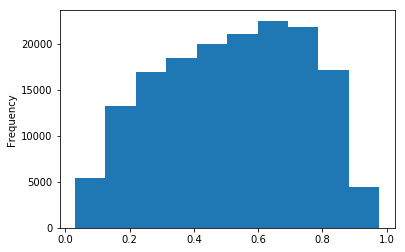

In [7]:
pd.Series(mask_pred_dict).plot.hist()